In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
import statsmodels.formula.api as smf
from math import exp
from sklearn import linear_model, cross_validation
import scipy.stats as prr
import numpy as np
from IPython.display import display, HTML

## Regression Class

In [2]:
class Regression:
    def __init__(self, pathToData):
        self.data = pd.read_csv(pathToData, index_col=0)

    def getDataFrame(self):
        return self.data

    
    
    # get collinearity (r^2 value) of a pair of columns
    def getCollinearityScore(self, dependentCol, independentCol):
        array = self.data.values
        X = array[:, independentCol]
        Y = array[:, dependentCol]

        return prr.pearsonr(X, Y)
        # GET SUBTABLE CONTAINING ONLY THE INDEPENDENT COLUMN AND DEPENDENT COLUMN
        # df2 = self.data.iloc[:, [independentCol, dependentCol]]
        # CREATE FITTED MODEL USING ORDINARY LEAST SQUARES REGRESSION
        # lm = smf.ols(formula='Sales ~ TV', data=df2).fit()
        # RETURN RSQUARED VALUE FOR THE MODEL
        # return lm.rsquared

    # print collinearities (r^2 value) of each pair of columns
    def printAllCollinearities(self):
        array = self.data.values
        length_col = self.data.shape[1]
        while(0 != length_col-1):
            for x in range(0, length_col-1):
                X = array[:, x]
                Y = array[:, length_col-1]

                print("Collinearity between "+self.data.columns.values[x]+" & "+self.data.columns.values[length_col-1]+" = "+str(prr.pearsonr(X, Y)))
            length_col -= 1

    def getSubTable(self, col_names):
        array = self.data
        return array.loc[:, col_names]
            
    def getFittedRegressionModel(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        model = linear_model.LinearRegression()
        model.fit(X, Y)
        m = model.coef_
        b = model.intercept_
        # print("Intercept=" + str(b) + " Coefficient=" + str(m))
        return model

    def getBestFeaturesRCEV(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        feature_names = self.data.columns.values
        model = linear_model.LinearRegression()
        selector = RFECV(estimator=model, cv=10)
        selector.fit(X, Y)
        print(selector.ranking_)
        print("Optimal number of features3: " + str(selector.n_features_))
        print(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), col_names)))
        print(selector.support_)
        


## Trip Generation Class

Generates travel demand scores per zone (trip production, trip attraction), given household characteristics

In [3]:
class TripGeneration:

    def __init__(self, pathToData, dependent_col_name):
        self.pathToData = pathToData
        self.dependent_col_name = dependent_col_name
        self.production_col_names = []
        self.production_constant = 0
        self.production_intercepts = []
        self.attraction_col_names = []
        self.attraction_constant = 0
        self.attraction_intercepts = []
        self.production_score = 0
        self.attraction_score = 0
        self.balancing_factor = 0
        
    def printAttributes(self):
        print("Attributes")
        print(self.production_col_names)
        print(self.production_constant)
        print(self.production_intercepts)
        print(self.attraction_col_names)
        print(self.attraction_constant)
        print(self.attraction_intercepts)

    def setProductionParameters(self, production_col_names, production_constant, production_intercepts):
        self.production_col_names = production_col_names
        self.production_constant = production_constant
        self.production_intercepts = production_intercepts
        
    def setAttractionParameters(self, attraction_col_names, attraction_constant, attraction_intercepts):
        self.attraction_col_names = attraction_col_names
        self.attraction_constant = attraction_constant
        self.attraction_intercepts = attraction_intercepts
        
    
    # get trip production score for 'zone'
    def getWholeTripProductionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.production_col_names]
        length_rows = sub_table.shape[0]
        production = 0
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            production = self.production_constant
            for j in range(0,len(row_values)):
                production += row_values[j]*self.production_intercepts[j]
            #print("prod_c: "+str(int(production)))
            self.production_score += int(production)
            #print("SELFPROD CURR: "+str(self.production_score))
        return int(self.production_score)

    # get trip attraction score for 'zone'
    def getWholeTripAttractionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.attraction_col_names]
        length_rows = sub_table.shape[0]
        attraction = 0
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            attraction = self.attraction_constant
            for j in range(0,len(row_values)):
                attraction += row_values[j]*self.attraction_intercepts[j]
            #print("attr_c: "+str(int(attraction)))
            self.attraction_score += int(attraction)
            #print("SELFATTR CURR: "+str(self.attraction_score))
        return int(self.attraction_score)
    
    def getZoneTripProductionScore(self, zone_number):
        self.production_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.production_score += self.production_constant
        for j in range(0,len(row_values)):
            self.production_score += row_values[j]*self.production_intercepts[j]

        return self.production_score
    
    def getZoneTripAttractionScore(self, zone_number):
        self.attraction_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.attraction_score += self.attraction_constant
        for j in range(0,len(row_values)):
            self.attraction_score += row_values[j]*self.attraction_intercepts[j]

        return self.attraction_score

    def doTripBalancing(self):
        self.balancing_factor = self.production_score/self.attraction_score
        self.attraction_score = self.balancing_factor * self.attraction_score
        self.production_score = self.balancing_factor * self.production_score
        # Implement trip balancing here VOID
        
    def getBalancingFactor(self):
        return self.balancing_factor
    
    def printAllZonalTripsProductionAttraction(self):
        productionScores = []
        attractionScores = []
        df = pd.DataFrame(columns=('Trip Production', 'Trip Atraction'))
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            attr_score = 0
            prod_score = 0
            attr_row_values = data.loc[x, self.attraction_col_names].values
            prod_row_values = data.loc[x, self.production_col_names].values
            attr_score += self.attraction_constant
            prod_score += self.production_constant
            for j in range(0,len(attr_row_values)):
                attr_score += attr_row_values[j]*self.attraction_intercepts[j]
            #print("attr_score: "+str(int(attr_score)))
            total_attraction += int(attr_score)
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            #print("prod_score: "+str(int(prod_score)))
            total_production += int(prod_score)
            df.loc[x] = [int(prod_score),int(attr_score)]
            productionScores.append(int(prod_score))
            attractionScores.append(int(attr_score))
            #print("Zone "+str(x)+": Production="+str(prod_score)+" , Attraction="+str(attr_score))
        #print(str(total_production)+":"+str(total_attraction))
        return df, productionScores, attractionScores;
        #print("Total Production="+str(total_production)+" , Total Attraction="+str(total_attraction))
        
    def getTripProductionScores(self):
        productionScores = []
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            prod_score = 0
            prod_row_values = data.loc[x, self.production_col_names].values
            prod_score += self.production_constant
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            total_production += prod_score
            productionScores.append(prod_score)
        return productionScores
    
    def getProductionSubTable(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        return data.loc[:, self.production_col_names]

        


# DATA
### Expected available parameters from the MMUTIS Update and Enhancement Project (MUCEP) Database

In [48]:
dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

,Trips,Establishments,Houses,Autos,Non-employed,Landuse_1,Landuse_2
1,5660,966,2880,1.2,2150,0,0
2,5520,633,2500,1.3,1550,0,1
3,5620,833,2820,2.1,1850,0,1
4,6560,766,3780,0.1,800,1,0
5,5800,800,3220,1.1,1900,0,0


### Zonal and Amenity data (OpenStreetMap)

In [49]:
dummy_data_amenities = pd.read_csv('AmenitiesData.csv', index_col=0)
dummy_data_amenities.head()

,Sustenance,Education,Transportation,Financial,Healthcare,Entertainment,Others
1,9,9,15,11,5,2,12
2,0,13,10,8,11,3,3
3,12,15,2,5,12,2,12
4,15,5,14,10,0,7,14
5,5,1,13,10,4,0,4


# DATA PREPARATION (Example Plan)

## Collinearity Checking using Peasrson Correlation (correlation coefficient, 2-tailed p-value)

In [50]:
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)
array = regression.getDataFrame().values
print("All collinearities:")
regression.printAllCollinearities()

All collinearities:
Collinearity between Trips & Landuse_2 = (-0.051589973601794424, 0.73945200555444213)
Collinearity between Establishments & Landuse_2 = (-0.21373857261925011, 0.16358199629021805)
Collinearity between Houses & Landuse_2 = (-0.13450086191910765, 0.38405000316927762)
Collinearity between Autos & Landuse_2 = (0.010665472200666524, 0.9452189068052762)
Collinearity between Non-employed & Landuse_2 = (0.051472707674347536, 0.74002355764983729)
Collinearity between Landuse_1 & Landuse_2 = (-0.6408699444616559, 2.7835795117912158e-06)
Collinearity between Trips & Landuse_1 = (0.013240271688484835, 0.93202183882932788)
Collinearity between Establishments & Landuse_1 = (0.13758129721958512, 0.37315236078452885)
Collinearity between Houses & Landuse_1 = (0.050537155896762227, 0.74458835296662185)
Collinearity between Autos & Landuse_1 = (0.03402731200238604, 0.82643412331102351)
Collinearity between Non-employed & Landuse_1 = (-0.10380696513512025, 0.50249469309347061)
Colline

### Checking for Optimal Features using Recursive Feature Elimination with Cross-Validation

In [51]:
col_names = regression.getDataFrame().columns.values[1:7]
dep_col_name = "Trips"
regression.getBestFeaturesRCEV(col_names, dep_col_name)
col_names

[1 1 1 1 1 1]
Optimal number of features3: 6
[(1, 'Autos'), (1, 'Establishments'), (1, 'Houses'), (1, 'Landuse_1'), (1, 'Landuse_2'), (1, 'Non-employed')]
[ True  True  True  True  True  True]


array(['Establishments', 'Houses', 'Autos', 'Non-employed', 'Landuse_1',
       'Landuse_2'], dtype=object)

### Verify Collinearity through Scatter Plots

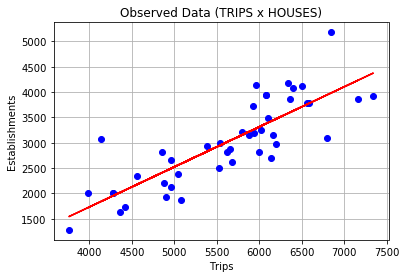

In [150]:
df = regression.getDataFrame()
plt.plot(df["Trips"], df["Houses"], 'bo')
x = df["Trips"]
y = df["Houses"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Trips')
plt.ylabel('Establishments')
plt.title('Observed Data (TRIPS x HOUSES)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

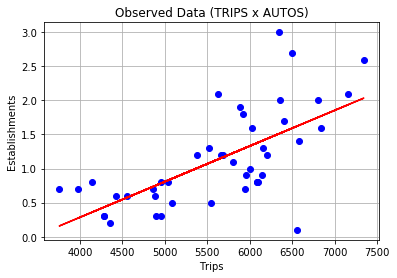

In [134]:
df = regression.getDataFrame()
plt.plot(df["Trips"], df["Autos"], 'bo')
x = df["Trips"]
y = df["Autos"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Trips')
plt.ylabel('Establishments')
plt.title('Observed Data (TRIPS x AUTOS)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

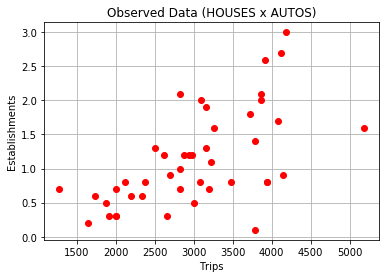

In [136]:
df = regression.getDataFrame()
plt.plot(df["Houses"], df["Autos"], 'ro')
x = df["Houses"]
y = df["Autos"]
plt.xlabel('Trips')
plt.ylabel('Establishments')
plt.title('Observed Data (HOUSES x AUTOS)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

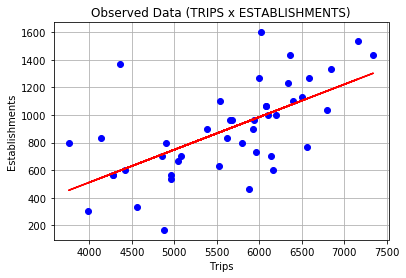

In [112]:
df = regression.getDataFrame()
plt.plot(df["Trips"], df["Establishments"], 'bo')
x = df["Trips"]
y = df["Establishments"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Trips')
plt.ylabel('Establishments')
plt.title('Observed Data (TRIPS x ESTABLISHMENTS)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

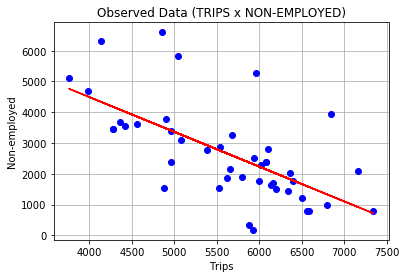

In [113]:
df = regression.getDataFrame()
plt.plot(df["Trips"], df["Non-employed"], 'bo')
x = df["Trips"]
y = df["Non-employed"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Trips')
plt.ylabel('Non-employed')
plt.title('Observed Data (TRIPS x NON-EMPLOYED)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

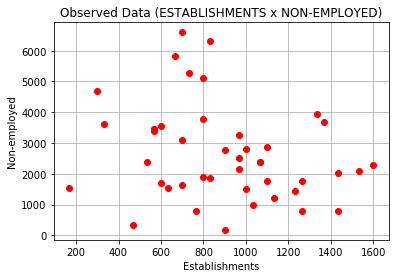

In [119]:
df = regression.getDataFrame()
plt.plot(df["Establishments"], df["Non-employed"], 'ro')
x = df["Establishments"]
y = df["Non-employed"]
plt.xlabel('Establishments')
plt.ylabel('Non-employed')
plt.title('Observed Data (ESTABLISHMENTS x NON-EMPLOYED)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

# MODEL FITTING
>BIC, AIC

### Retreival of intercepts and coefficients
**Features for Trip production**: # of HH, # of HH members, # of employed, # of enrolled, Income, Landuse and Amenity Data

**Features for Trip attraction**: # of Establishments, # of working in area, # of enrolled in area, Landuse and Amenity Data

In [52]:
selected_feature_names = ["Houses", "Autos"]
selected_feature_names_attraction = ["Non-employed", "Establishments"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

,Trips,Establishments,Houses,Autos,Non-employed,Landuse_1,Landuse_2
1,5660,966,2880,1.2,2150,0,0
2,5520,633,2500,1.3,1550,0,1
3,5620,833,2820,2.1,1850,0,1
4,6560,766,3780,0.1,800,1,0
5,5800,800,3220,1.1,1900,0,0


### Prediction of Trip Production & Attraction using the intercepts and coefficients

In [53]:
trip_gen = TripGeneration("DummyDataRegression.csv", "Trips")
prod_col_names = selected_feature_names
attr_col_names = selected_feature_names_attraction
trip_gen.setProductionParameters(prod_col_names, fitted_production_model.intercept_, fitted_production_model.coef_)
trip_gen.setAttractionParameters(attr_col_names, fitted_production_model_attr.intercept_, fitted_production_model_attr.coef_)
print("Example:")
print("Overall Trip Production: "+str(trip_gen.getWholeTripProductionScore()))
print("Overall Trip Attraction: "+str(trip_gen.getWholeTripAttractionScore()))

Example:
Overall Trip Production: 247000
Overall Trip Attraction: 246997


### Computing for Trip Balancing Factor

In [54]:
trip_gen.doTripBalancing()
print("Balancing Factor: "+str(trip_gen.getBalancingFactor()))


Balancing Factor: 1.0000121458965088


### Zonal-level Trip Production & Attraction Scores

In [55]:
zonal_df, productions, attractions = trip_gen.printAllZonalTripsProductionAttraction()
display(zonal_df)

,Trip Production,Trip Atraction
1,5545.0,5866.0
2,5307.0,5613.0
3,5793.0,5783.0
4,5828.0,6015.0
5,5754.0,5725.0
6,6335.0,6381.0
7,4876.0,5231.0
8,4968.0,4589.0
9,5841.0,5712.0
10,4609.0,5229.0


# Model Validation


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
X_digits = regression.getSubTable(selected_feature_names)
Y_digits = regression.getSubTable(dep_col_name)
scores = cross_validation.cross_val_score(fitted_production_model, X_digits, Y_digits, scoring='r2', cv=10,)
#X_digits.shape, Y_digits.shape
scores

# MODEL OUTPUT

# Trip Distribution Class

In [56]:
class TripDistribution:

    def __init__(self, productions, attractions):
        self.productions = productions
        self.attractions = attractions
        self.row = len(productions)
        self.col = len(attractions)
        self.possibleError = 3
        self.error = 0

    def getGeneralizedCost(self, cost):
        return 1.0 / (cost * cost)

    def getTripDistribution(self):
        distributions = [[self.attractions[y] for x in range(self.row)] for y in range(self.col)]
        costMatrix = [[1 for x in range(self.row)] for y in range(self.col)]
        #costMatrix = [[1.0, 1.2, 1.8], [1.2, 1.0, 1.5], [1.8, 1.5, 1.0]]
        A = [1 for x in range(self.row)]
        B = [1 for x in range(self.col)]

        currentBalancingFactor = 0  # 0 for A, 1 for B
        isConvergent = False

        while isConvergent == False:
            if currentBalancingFactor == 0:
                A = self.computeA(B, costMatrix)
                currentBalancingFactor = 1
            elif currentBalancingFactor == 1:
                B = self.computeB(A, costMatrix)
                currentBalancingFactor = 0
            distributions = self.computeDistributions(A, B, costMatrix)
            isConvergent = self.checkIfConvergent(distributions)
        return distributions

    def computeDistributions(self, A, B, costMatrix):
        distributions = [[self.attractions[y] for x in range(self.row)] for y in range(self.col)]
        for x in range(self.row):
            for y in range(self.col):
                distributions[x][y] = A[x] * self.productions[x] * B[y] * self.attractions[y] * self.getGeneralizedCost(costMatrix[x][y])
        return distributions

    def checkIfConvergent(self, distributions):
        error = self.getError(distributions)
        if error <= self.possibleError:
            self.error = error
            return True
        return False

    def getError(self, distributions):
        error = 0
        derivedProductions = [0 for x in range(self.row)]
        derivedAttractions = [0 for x in range(self.col)]

        for x in range(self.row):
            for y in range(self.col):
                derivedProductions[x] += distributions[x][y]
                derivedAttractions[y] += distributions[x][y]

        for x in range(self.row):
            error += abs(derivedProductions[x] - self.productions[x])
            error += abs(derivedAttractions[y] - self.attractions[y])

        return error

    def computeA(self, B, costMatrix):
        A = [1 for x in range(self.row)]
        for x in range(0, self.row):
            sum = 0.0
            for y in range(0, self.col):
                sum += B[y] * self.attractions[y] * self.getGeneralizedCost(costMatrix[x][y])
            A[x] = 1.0 / sum
        return A

    def computeB(self, A, costMatrix):
        B = [1 for x in range(self.col)]
        for x in range(0, self.row):
            sum = 0.0
            for y in range(0, self.col):
                sum += A[y] * self.productions[y] * self.getGeneralizedCost(costMatrix[x][y])
            B[x] = 1.0 / sum
        return B

# Data

## The result from trip generation (trip production and attraction) will be passed to trip distribution

In [57]:
td = TripDistribution(productions, attractions)

print("Productions: " + str(productions))
print("Attractions: " + str(attractions))

Productions: [5545, 5307, 5793, 5828, 5754, 6335, 4876, 4968, 5841, 4609, 5587, 5438, 5320, 4629, 6248, 5616, 5061, 5776, 7307, 6531, 5959, 6168, 5098, 6735, 6909, 4868, 4573, 6499, 5558, 6558, 5341, 7049, 4759, 5969, 4542, 5944, 6342, 6168, 5610, 4247, 4629, 4342, 5360, 5404]
Attractions: [5866, 5613, 5783, 6015, 5725, 6381, 5231, 4589, 5712, 5229, 5589, 6380, 5678, 4947, 6669, 6108, 4355, 5524, 5798, 6630, 6303, 5928, 4970, 6895, 6373, 5010, 5154, 6514, 4429, 6163, 4163, 6428, 4219, 5760, 4961, 6649, 4610, 5928, 5752, 4743, 4947, 5925, 5531, 5820]


The following formula, which is from a book, Introduction to Transportation Engineering by Tom V. Mathew and K V Krishna Rao, is used:

$$T_{ij} = A_iO_iB_jD_jf(c_{ij})$$

Where $T_{ij}$ is the trips made from zone i to the zone j, $O_i$ refers to the trip productions made from zone i, $D_j$ refers to the trip attractions made from zone j, $c_{ij}$ is the general cost used from zone i to zone j, $A_i$ and $B_i$ are the balancing factor and the following formula are used:

 $$A_i = 1 / \sum_{j} B_{j}D_jf(c_{ij})$$
 $$B_i = 1 / \sum_{i} A_{i}O_if(c_{ij})$$
 
At first, one of the balancing factors will be set to 1s and the other will be compupted using the formula above. This will be done alternately until the some of all the origins or the destinations of the computed distributions will be close to the original productions and attractions. $Lastly, the function $f(c_{ij})$ has the following formula:
$$f(c_{ij}) = 1/c_{ij}^2$$



In [59]:
distribution = td.getTripDistribution()

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in distribution)
        )
))

131.68813765182188,126.00844129554658,129.8248380566802,135.03309716599193,128.52277327935224,143.24957489878545,117.43277327935225,103.02026315789475,128.23093117408908,117.38787449392714,125.46965587044537,143.2271255060729,127.46765182186236,111.05714574898788,149.71500000000003,137.12089068825912,97.76710526315792,124.01044534412958,130.16157894736844,148.83947368421056,141.4985222672065,133.08,111.57348178137653,154.78856275303647,143.06997975708504,112.47145748987856,115.70417004048585,146.23534412955468,99.42836032388665,138.3556072874494,93.45682186234819,144.30469635627531,94.71398785425103,129.30850202429153,111.37143724696358,149.26601214574902,103.49170040485832,133.08,129.1289068825911,106.47746963562754,111.05714574898788,133.01265182186236,124.16759109311742,130.65546558704455
126.03587854251015,120.59996356275306,124.25255465587047,129.23726720647775,123.00637651821864,137.10108097165994,112.39237651821864,98.59847368421055,122.72706072874496,112.34940485829962,120.08430364372472,137.07959514170042,121.99654251012149,106.29040080971662,143.28900000000002,131.23544939271258,93.57078947368423,118.6877246963563,124.57484210526319,142.451052631579,135.42518623481783,127.36800000000002,106.78457489878545,148.14479757085024,136.92919433198384,107.64400809716601,110.73796761133606,139.95869635627534,95.16074089068827,132.41717004048584,89.4455101214575,138.11091497975713,90.64871659919031,123.75838056680165,106.59120242914982,142.85928340080974,99.04967611336035,127.36800000000002,123.58649392712553,101.90729149797573,106.29040080971662,127.30354251012149,118.8381255060729,125.04753036437249
137.57788663967614,131.64416599190284,135.63125101214575,141.07244939271257,134.27095141700406,149.6564089068826,122.68495141700406,107.62784210526317,133.96605668016196,122.63804453441297,131.08128340080972,149.63295546558706,133.16863967611337,116.02417408906884,156.41100000000003,143.2536194331984,102.13973684210528,129.55680971659922,135.98305263157897,155.4963157894737,147.82704048582997,139.032,116.5636032388664,161.71147773279355,149.46878137651822,117.50174089068827,120.87903643724698,152.7757165991903,103.87529149797572,144.54355870445346,97.63667611336034,150.7587206477733,98.95006882591095,135.09182186234818,116.3525222672065,155.9419311740891,108.12036437246965,139.032,134.90419433198383,111.23967206477734,116.02417408906884,138.96163967611338,129.72098380566803,136.499028340081
138.40910121457492,132.4395303643725,136.45070445344132,141.92477732793526,135.08218623481784,150.56059919028343,123.42618623481783,108.27810526315791,134.77544939271257,123.37899595141702,131.87324696356276,150.53700404858301,133.9732145748988,116.72516599190286,157.35600000000002,144.1191255060729,102.75684210526317,130.33956275303646,136.80463157894738,156.43578947368425,148.72017813765186,139.872,117.26785425101217,162.68850202429152,150.3718380566802,118.21165991902836,121.60936032388666,153.69875303643727,104.50288259109314,145.41685829959516,98.22657489878544,151.66957085020246,99.54790283400811,135.90801619433202,117.05549797570852,156.88409716599193,108.77360323886641,139.872,135.71925506072876,111.91175708502027,116.72516599190286,139.8012145748988,130.50472874493929,137.3237246963563
136.65167611336034,130.75790283400812,134.7181457489879,140.1227125506073,133.36700404858303,148.64888259109316,121.85900404858302,106.90326315789476,133.06416194331987,121.81241295546562,130.19880971659921,148.62558704453446,132.2721133603239,115.24306882591095,155.35800000000003,142.28919838056683,101.45210526315792,128.68459919028342,135.06757894736845,154.44947368421055,146.8318299595142,138.09600000000003,115.77886639676116,160.62279352226724,148.4625182186235,116.71068825910933,120.06524696356277,151.74719028340084,103.17597570850205,143.57045344129557,96.97936032388665,149.74377327935227,98.2839109311741,134.1823481781377,115.56920647773282,154.89208906882595,107.39246963562755,138.09600000000003,133.99598380566803,110.49077732793525,115.243068825

# Error

In [60]:
print("Error: " + str(td.error))

Error: 2.9999999999936335


# Modal Split Class

Modal split is the part where we partition a total number of trips to determine how much uses the different modes of transportation (i.e. in 5000 trips, 40% use jeepneys, 40% use bus and 20% use train)

In [61]:
import random
class ModalSplit:

    def __init__(self, od_matrix, pathToData):
        self.od_matrix = od_matrix
        self.pathToData = pathToData
        self.travel_costs = []
        self.travel_probabilities = []
        self.modes = ['jeep','bus','train']
        
    def computeGeneralizedCosts(self, zone_number):
        #data = pd.read_csv(self.pathToData, index_col=0)
        self.travel_costs = [None] * len(self.modes)
        for x in range(0, len(self.modes)):
            self.travel_costs[x] = random.randrange(1,4)
            
        #Compute for generalized cost for each mode for this specific zone
        # populate self.travel_costs with the travel costs
        self.computeModalProbabilities()
        
    def computeModalProbabilities(self):
        self.travel_probabilities = [None] * len(self.modes)
        sum = 0
        #print(len(self.travel_costs))
        for x in range(0,3):
            sum += exp(-self.travel_costs[x])
        for x in range(0,3):
            self.travel_probabilities[x] = exp(-self.travel_costs[x])/sum
        #print(self.travel_costs)
        #print(self.travel_probabilities)
    
    def getPartitionedTripsByMode(self, total_trips):
        return total_trips*self.travel_probabilities[0], self.travel_probabilities[1], self.travel_probabilities[2]
    
    def process_od_matrix(self):
        #print("size:"+str(len(self.od_matrix))+","+str(len(self.od_matrix[0])))
        #df = DataFrame(columns=('lib', 'qty1', 'qty2'))
        #for i in range(5):
            #df.loc[i] = [randint(-1,1) for n in range(3)]
        cols = list(range(len(self.od_matrix[0])))
        df_list = []
        for x in range(0, len(self.modes)):
            df = pd.DataFrame(columns=cols) 
            df_list.append(df)
            
        for y in range(0, len(self.od_matrix)):
            self.computeGeneralizedCosts(y)
            for z in range(0, len(self.modes)):
                od_row = []
                for x in range(0, len(self.od_matrix[0])):
                    #print("x:"+str(x)+" y:"+str(y)+" z:"+str(z))
                    od_row.append(round(self.od_matrix[x][y]*self.travel_probabilities[z],2))
                df_list[z].loc[y] = od_row
                
        return df_list
                

## Generalized Cost of Travel

a measure combining all the main attributes (fare price, travel time, convenience) related to the disutility of using a specific transportation mode

$$C_{ij} = a_{1}t_{ij}^{v} + a_{2}t_{ij}^{w} + a_{3}t_{ij}^{c} .. a_{n}t_{ij}^{x}$$

## Logit Model

The relationship is normally expressed by a logit curve. Therefore, the proportion of
trips by a certain mode is given by:

$$P_{ij}^{1} = \frac{e^{-\beta c_{ij}^{1}}}{\sum e^{-\beta c_{ij}^{m}}}$$

In [62]:
modal_split = ModalSplit(distribution,"datapath")
list_of_dataframes_by_mode = modal_split.process_od_matrix()

## Mode 1

In [63]:
display(list_of_dataframes_by_mode[0])

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,43.90,42.01,45.86,46.14,45.55,50.15,38.60,39.33,46.24,36.49,...,35.96,47.05,50.21,48.83,44.41,33.62,36.64,34.37,42.43,42.78
1,53.22,50.93,55.60,55.93,55.22,60.80,46.80,47.68,56.06,44.23,...,43.59,57.04,60.86,59.19,53.84,40.76,44.42,41.67,51.44,51.86
2,86.36,82.66,90.23,90.77,89.62,98.67,75.94,77.38,90.98,71.79,...,70.74,92.58,98.78,96.07,87.38,66.15,72.10,67.63,83.48,84.17
3,45.01,43.08,47.02,47.31,46.71,51.42,39.58,40.33,47.41,37.41,...,36.87,48.25,51.48,50.07,45.54,34.47,37.58,35.25,43.51,43.87
4,42.84,41.00,44.76,45.03,44.46,48.94,37.67,38.38,45.13,35.61,...,35.09,45.92,49.00,47.65,43.34,32.81,35.76,33.55,41.41,41.75
5,67.09,64.21,70.09,70.51,69.61,76.64,58.99,60.10,70.67,55.76,...,54.95,71.91,76.73,74.62,67.87,51.38,56.00,52.53,64.85,65.38
6,55.00,52.63,57.45,57.80,57.07,62.83,48.36,49.27,57.93,45.71,...,45.05,58.95,62.90,61.17,55.64,42.12,45.91,43.06,53.16,53.60
7,34.34,32.87,35.88,36.09,35.63,39.23,30.20,30.77,36.17,28.54,...,28.13,36.81,39.28,38.20,34.74,26.30,28.67,26.89,33.19,33.47
8,19.92,19.07,20.81,20.94,20.67,22.76,17.52,17.85,20.99,16.56,...,16.32,21.36,22.79,22.16,20.16,15.26,16.63,15.60,19.26,19.42
9,67.63,64.73,70.65,71.08,70.18,77.26,59.47,60.59,71.24,56.21,...,55.40,72.50,77.35,75.23,68.42,51.80,56.46,52.96,65.37,65.91


## Mode 2

In [64]:
display(list_of_dataframes_by_mode[1])

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,43.90,42.01,45.86,46.14,45.55,50.15,38.60,39.33,46.24,36.49,...,35.96,47.05,50.21,48.83,44.41,33.62,36.64,34.37,42.43,42.78
1,19.58,18.74,20.45,20.58,20.31,22.37,17.22,17.54,20.62,16.27,...,16.04,20.99,22.39,21.78,19.81,14.99,16.34,15.33,18.92,19.08
2,31.77,30.41,33.19,33.39,32.97,36.30,27.94,28.47,33.47,26.41,...,26.02,34.06,36.34,35.34,32.14,24.33,26.52,24.88,30.71,30.96
3,45.01,43.08,47.02,47.31,46.71,51.42,39.58,40.33,47.41,37.41,...,36.87,48.25,51.48,50.07,45.54,34.47,37.58,35.25,43.51,43.87
4,42.84,41.00,44.76,45.03,44.46,48.94,37.67,38.38,45.13,35.61,...,35.09,45.92,49.00,47.65,43.34,32.81,35.76,33.55,41.41,41.75
5,9.08,8.69,9.49,9.54,9.42,10.37,7.98,8.13,9.56,7.55,...,7.44,9.73,10.38,10.10,9.19,6.95,7.58,7.11,8.78,8.85
6,7.44,7.12,7.78,7.82,7.72,8.50,6.54,6.67,7.84,6.19,...,6.10,7.98,8.51,8.28,7.53,5.70,6.21,5.83,7.19,7.25
7,34.34,32.87,35.88,36.09,35.63,39.23,30.20,30.77,36.17,28.54,...,28.13,36.81,39.28,38.20,34.74,26.30,28.67,26.89,33.19,33.47
8,54.15,51.83,56.58,56.92,56.20,61.87,47.62,48.52,57.05,45.01,...,44.36,58.05,61.94,60.24,54.79,41.48,45.21,42.41,52.35,52.78
9,24.88,23.81,25.99,26.15,25.82,28.42,21.88,22.29,26.21,20.68,...,20.38,26.67,28.46,27.67,25.17,19.06,20.77,19.48,24.05,24.25


## Mode 3

In [65]:
display(list_of_dataframes_by_mode[2])

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,43.90,42.01,45.86,46.14,45.55,50.15,38.60,39.33,46.24,36.49,...,35.96,47.05,50.21,48.83,44.41,33.62,36.64,34.37,42.43,42.78
1,53.22,50.93,55.60,55.93,55.22,60.80,46.80,47.68,56.06,44.23,...,43.59,57.04,60.86,59.19,53.84,40.76,44.42,41.67,51.44,51.86
2,11.69,11.19,12.21,12.28,12.13,13.35,10.28,10.47,12.31,9.72,...,9.57,12.53,13.37,13.00,11.83,8.95,9.76,9.15,11.30,11.39
3,45.01,43.08,47.02,47.31,46.71,51.42,39.58,40.33,47.41,37.41,...,36.87,48.25,51.48,50.07,45.54,34.47,37.58,35.25,43.51,43.87
4,42.84,41.00,44.76,45.03,44.46,48.94,37.67,38.38,45.13,35.61,...,35.09,45.92,49.00,47.65,43.34,32.81,35.76,33.55,41.41,41.75
5,67.09,64.21,70.09,70.51,69.61,76.64,58.99,60.10,70.67,55.76,...,54.95,71.91,76.73,74.62,67.87,51.38,56.00,52.53,64.85,65.38
6,55.00,52.63,57.45,57.80,57.07,62.83,48.36,49.27,57.93,45.71,...,45.05,58.95,62.90,61.17,55.64,42.12,45.91,43.06,53.16,53.60
7,34.34,32.87,35.88,36.09,35.63,39.23,30.20,30.77,36.17,28.54,...,28.13,36.81,39.28,38.20,34.74,26.30,28.67,26.89,33.19,33.47
8,54.15,51.83,56.58,56.92,56.20,61.87,47.62,48.52,57.05,45.01,...,44.36,58.05,61.94,60.24,54.79,41.48,45.21,42.41,52.35,52.78
9,24.88,23.81,25.99,26.15,25.82,28.42,21.88,22.29,26.21,20.68,...,20.38,26.67,28.46,27.67,25.17,19.06,20.77,19.48,24.05,24.25
